# GlobalAveragePooling (GAP)
- Feature map의 채널별로 평균값을 추출 1 x 1 x channel 의 Feature map을 생성
- `model.add(keras.layers.GlobalAveragePooling2D())`
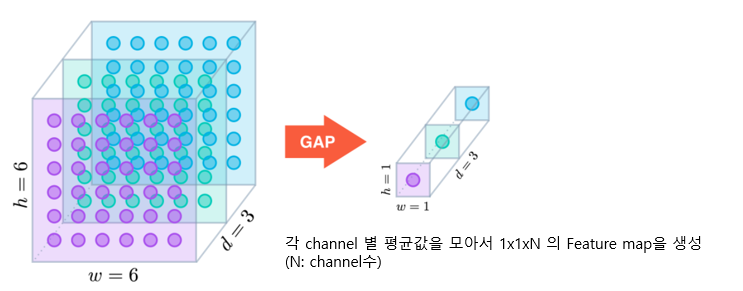

- Feature Extraction layer에서 추출한 Feature map을 Classifier layer로 Flatten해서 전달하면 많은 연결노드와 파라미터가 필요하게 된다. GAP를 사용하면 노드와 파라미터의 개수를 효과적으로 줄일 수 있다.
- Feature map의 채널수가 많을 경우 GAP를 사용하는 것이 효과적이나 채널수가 적다면 Flatten을 사용하는 것이 좋다. (최소 512개)
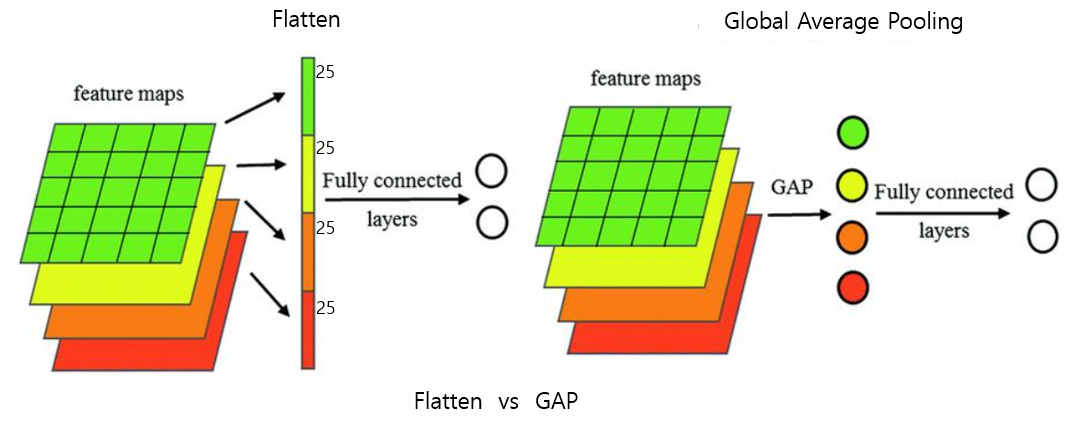

In [ ]:
# 이미지 다운로드
import gdown
url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'
gdown.download(url, fname, quiet=False)

In [ ]:
!mkdir data

In [ ]:
## 압축 풀기
!unzip -q ./cats_and_dogs_small.zip -d data/cats_and_dogs_small

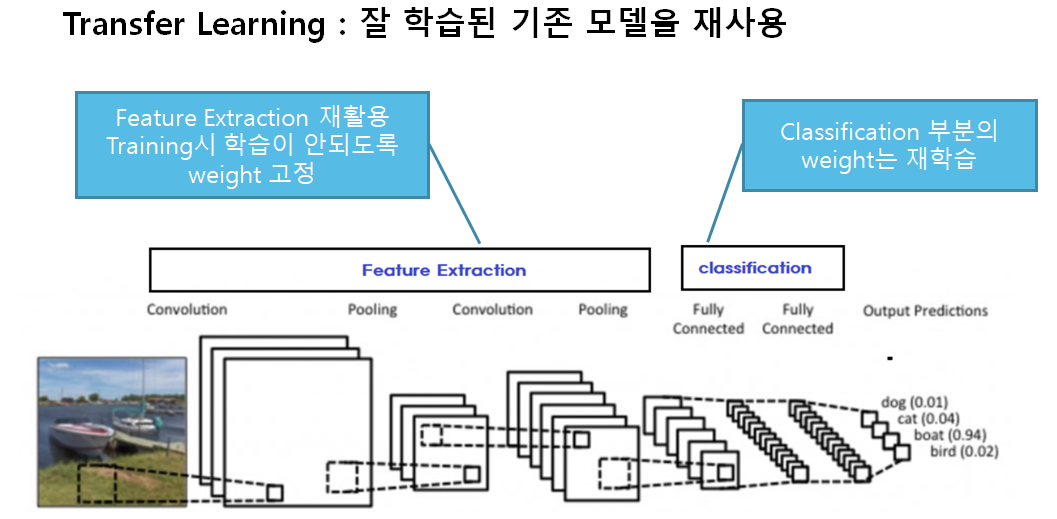

## Transfer learning (전이학습)
- 큰 데이터 셋을 이용해 미리 학습된 pre-trained Model의 Weight를 사용하여 현재 하려는 예측 문제에 활용. 
- ### Convolution base(Feature Extraction 부분)만 활용
    - Convolution base는 이미지에 나타나는 일반적인 특성을 파악하기 위한 부분이므로 재사용할 수 있다.
    - Classifier 부분은 학습하려는 데이터셋의 class들에 맞게 변경 해야 하므로 재사용할 수 없다.
- Pretrained Convlution layer의 활용 
    - Feature extraction
        - 학습시 학습되지 않고 Feature를 추출하는 역할만 한다.
    - Fine tuning
        - 학습시 Pretrained Covolution layer도 같이 학습해서 내 데이터셋에 맞춘다.

## Feature extraction
- 기존의 학습된 network에서 fully connected layer를 제외한 나머지 weight를 고정하고 새로운 목적에 맞는 fully connected layer를 추가하여 추가된 weight만 학습하는 방법
- `tensorflow.keras.applications` module이 지원하는  image classification models
    - (https://www.tensorflow.org/api_docs/python/tf/keras/applications)    

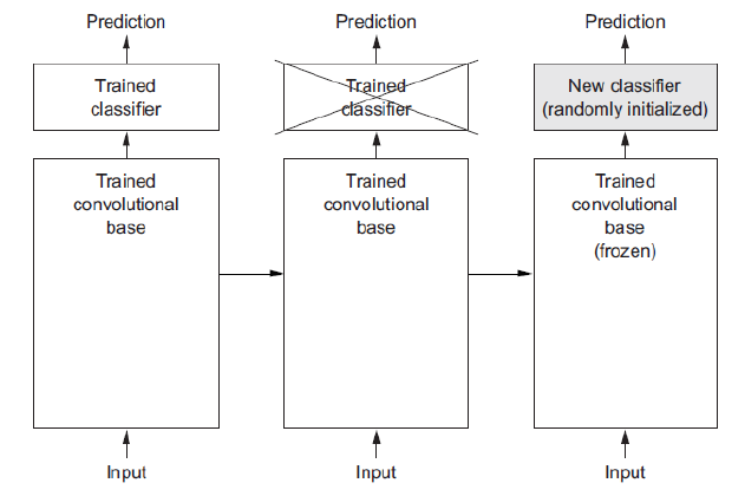

# Pre-Trained Model(미리 학습된 모델)을 이용한 전이학습

## Keras에서 제공하는 Pre-Trained Model 
- tensorflow.keras.applications 패키지를 통해 제공
    - https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko
    - Modules
        - 각 모델 생성 함수와 전처리 함수제공
    - Functions
        - 모델 생성함수 제공
- 모델 생성함수의 주요 매개변수
    - `weights`: 모형의 학습된 weight. 기본값- 'imagenet'
    - `include_top`: fully connected layer를 포함할지 여부. True 포함시킴, False: 포함 안 시킴
    - `input_shape`: 사용자가 입력할 이미지의 크기 shape. 3D 텐서로 지정. (높이, 너비, 채널). 기본값: (224,224, 3)

In [1]:
from tensorflow import keras

In [3]:
# keras pretrained 모델 조회
vgg16 = keras.applications.VGG16(weights='imagenet',
                                 include_top=False,   # classificatoin layer를 가져올지 여부
                                 input_shape=(224,224,3))

58892288/58889256 [==============================] - 2s 0us/step


In [5]:
vgg16.summary()   # dense layer가 없음

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
vgg16_2 = keras.applications.VGG16(weights='imagenet',
                                 include_top=True,   # classificatoin layer(fully_connected layer)를 가져올지 여부
                                 input_shape=(224,224,3))

553467904/553467096 [==============================] - 21s 0us/step


In [7]:
vgg16_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
resnet50 = keras.applications.ResNet50V2(include_top=False)   # input_shape=(224,224,3), weights='imagenet'는 default 사용

94674944/94668760 [==============================] - 3s 0us/step


In [9]:
resnet50.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

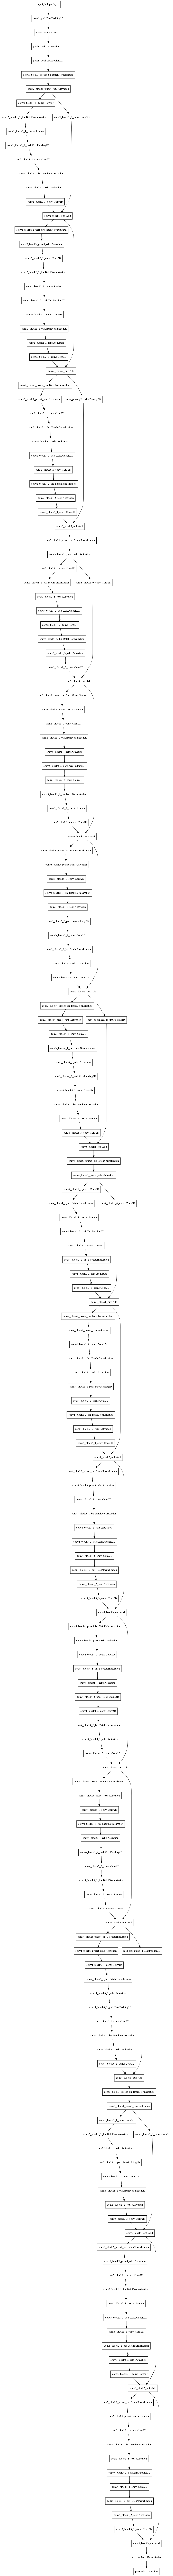

In [10]:
keras.utils.plot_model(resnet50)

In [11]:
mobilenet = keras.applications.MobileNet(include_top=False)

17227776/17225924 [==============================] - 1s 0us/step


In [12]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 

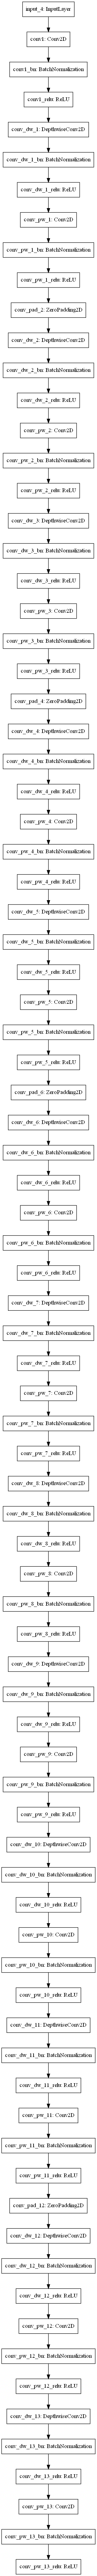

In [13]:
keras.utils.plot_model(mobilenet)

## Feature extraction의 두 가지 방법
1. **빠른 추출방식**
    - 예측하려는 새로운 데이터를 위의 `conv_base`에 입력하여 나온 출력값을 numpy 배열로 저장하고 이를 분류 모델의 입력값으로 사용. Convolution operation을 하지 않아도 되기 때문에 빠르게 학습. 하지만 data augmentation 방법을 사용할 수 없음.

2. **받아온 특성 Layer를 이용해 새로운 모델 구현하는 방식**
    - 위의 `conv_base` 이후에 새로운 layer를 쌓아 확장한 뒤 전체 모델을 다시 학습. 모든 데이터가 convolution layer들을 통과해야 하기 때문에 학습이 느림. 단 conv_base의 가중치는 업데이트 되지 않도록 한다. data augmentation 방법을 사용할 수 있음.

### 빠른 특성 추출 방식


- `conv_base`의 predict 메소드로 입력 이미지의 feature를 추출 

## Pretrained Network를 이용해 새로운 모델 구현하는 방식

- Conv_base의 feature extraction 부분에 fully connected layer를 추가하여 모형 생성 
- Conv_base에서 가져온 부분은 학습을 하지 않고 weight를 고정
    -  **Layer.trainable=False**

## 미세조정(Fine-tuning)
- Pretrained 모델을 내가 학습시켜야 하는 데이터셋(Custom Dataset)에 재학습시키는 것을 fine tunning 이라고 한다.
- 주어진 문제에 더 적합하도록 모델의 가중치들을 조정.

### Fine tuning 전략
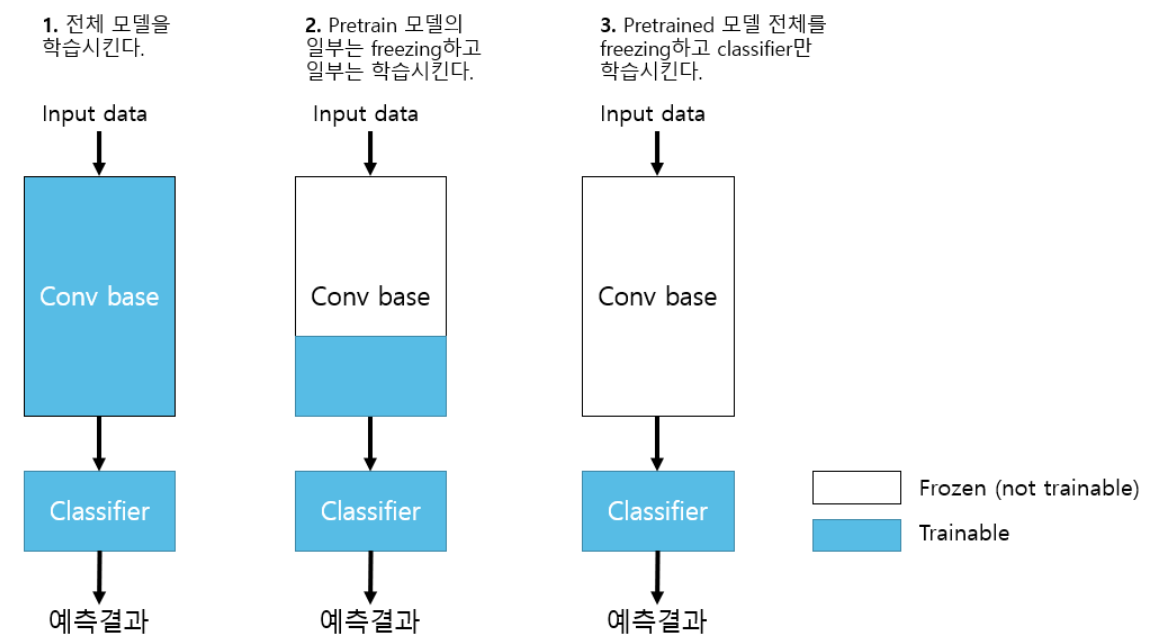

- **세 전략 모두 classifier layer들은 train한다.**

1. <span style="font-size:1.2em;font-weight:bold">전체 모델을 전부 학습시킨다.(1번)</span>
    - Pretrained 모델의 weight는 Feature extraction 의 초기 weight 역할을 한다.
    - **Train dataset의 양이 많고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **낮은 경우** 적용.
    - 학습에 시간이 많이 걸린다.
2. <span style="font-size:1.2em;font-weight:bold">Pretrained 모델 Bottom layer들(Input과 가까운 Layer들)은 고정시키고 Top layer의 일부를 재학습시킨다.(2번)</span>
    - **Train dataset의 양이 많고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **높은 경우** 적용.
    - **Train dataset의 양이 적고** Pretained 모델이 학습했던 dataset과 custom dataset의 class간의 유사성이 **낮은 경우** 적용
3. <span style="font-size:1.2em;font-weight:bold">Pretrained 모델 전체를 고정시키고 classifier layer들만 학습시킨다.(3번)</span>
    - **Train dataset의 양이 적고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **높은 경우** 적용.
  
  
> custom dataset: 내가 학습시키고자 하는 dataset 

## Model, Layer에서 weight 조회

### Model에서 Layer들 조회
- model객체.layers
    - 모델을 구성하는 layer 객체들을 담은 리스트
- model객체.get_layer(Layer이름:str)
    - argument로 전달한 이름의 Layer객체를 반환
    
### Model과 Layer의 weight들 조회 및 설정
- Layer와 Model은 Weight조회와 관련해 세가지 속성을 제공
    - weights: 레이어의 모든 weight 변수들을 담은 리스트
        - get_weights() : 레이어의 모든 weight 변수 리스트를 카피해서 반환한다.
    - trainable_weights: Train(학습)시 업데이트 되는 weights들 리스트
    - non_trainable_weights: Train(학습)시 업데이트 되지 않는(훈련되지 않는) weights들 리스트
- Layer와 Model은 boolean 값을 가지는 속성 `trainable`을 제공
    - trainable을 False로 설정하면 Layer의 weights들이 훈련가능에서 **훈련 불가능** 상태로 변경된다. 이런 상태를 **Frozen-동결** 이라고 하며 학습시 weight들이 업데이트 되지 않는다.

### Pretrained 모델 Bottom layer들(Input과 가까운 Layer들)은 고정시키고 Top layer의 일부를 재학습

- Conv_base에서 가장 Top부분에 있는 레이어에 대해 fine-tuning.
    - 앞의 layer들은 비교적 일반적이고 재사용 가능한 feature를 학습
    - 너무 많은 parameter를 학습시키면 overfitting의 위험이 있음 (특히 새로운 데이터의 수가 적을 때)